# Diagramación de una Chacra para Forestería Análoga

### © Equipo I+D SomosAZUCAR - Bajo licencia AGPLv3

```
Diagramador de Planos para Forestería Análoga
Copyright (C) 2015 Sebastian Silva

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
# Bibliotecas utilizadas para confeccionar el mapa
%matplotlib inline
import matplotlib.pyplot as plt
from shapely import geometry
import numpy as np
import pandas as pd
import random
import mpld3
from tqdm import tqdm
#import cartopy.crs as ccrs

## 1.- DATOS INICIALES
### © Arbio - licencia por definir

La base de datos consiste en una lista de especies, cantidades, diámetro y otras características.

In [2]:
especies = pd.read_csv("db_final.csv") ## Es una base
especies = especies.sort('Estrato', ascending=False)
especies_medicinal = especies[(especies.Usos=="Medicinal")]
especies_frutal = especies[(especies.Usos=="Frutal")]

In [3]:
consolidado_frutal = pd.DataFrame({'especies':especies_frutal.groupby('Estrato').size(), 
                            'individuos':especies_frutal.groupby('Estrato')['ind'].sum()})
pd.concat([consolidado_frutal,pd.DataFrame(consolidado_frutal.sum(axis=0),columns=['Total']).T])



,especies,individuos
Estrato,,
1,4,612
2,6,234
3,8,56
4,7,28
5,2,8
Total,27,938


In [5]:
consolidado_medicinal = pd.DataFrame({'especies':especies_medicinal.groupby('Estrato').size(), 
                            'individuos':especies_medicinal.groupby('Estrato')['ind'].sum()})
pd.concat([consolidado_medicinal,pd.DataFrame(consolidado_medicinal.sum(axis=0),columns=['Total']).T])


,especies,individuos
Estrato,,
1,4,612
2,6,132
3,8,56
4,7,28
5,2,8
Total,27,836


## 2.- LINDEROS DE LA CHACRA

Los linderos están definidos como un polígono en metros, desde una de las esquinas.

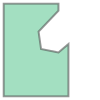

In [6]:
chacra1 = geometry.Polygon([ [0,0],
                            [0, 93],
                            [55, 93],
                            [55, 86],
                            [35, 65],
                            [37.5, 47.5],
                            [55, 44],
                            [65, 52.5],
                            [65, 0] ])
chacra1

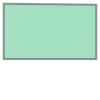

In [7]:
chacra2 = geometry.Polygon([ [0,0],
                            [0, 55],
                            [92, 54],
                            [92,0], 
                          ])
chacra2

## 3.- Definir ubicaciones

In [42]:
def punto_aleatorio(poligono):
    (minx, miny, maxx, maxy) = poligono.bounds
    while True:
        p = geometry.Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if poligono.contains(p):
            return(p)

In [262]:
class Poblacion:
    def __init__(self, poligono, especies, intentos=100):
        self.superficie = poligono
        individuos_columns = ['id', 'pos', 'x', 'y', 'color', 'Diametro.dosel', 'Nombre', 
                              'cantidad_inubicada']
        self.individuos = pd.DataFrame(columns=individuos_columns, )
        individuos_n = 0
        
        self.inubicables = dict()
        
        #self.inubicables.loc[0] = [0, '']
        
        for especie in tqdm(list(especies.itertuples())):
            n_especie = especie[0]
            color_especie = np.random.rand(3,)
            planta_tipo = especies.loc[n_especie]
            total = len(self.individuos)
            for n_individuo in range(especies.ind[n_especie]):
                individuos_n = individuos_n + 1
                planta = planta_tipo.copy()
                planta['id'] = n_especie
                
                planta = ubicar(self, planta, intentos)
                
                if planta['pos']:
                    planta['color'] = color_especie
                    planta['diametro'] = int(float(planta['Diametro.dosel'])*30)
                    self.individuos.loc[individuos_n] = planta
                else:
                    contador = self.inubicables.get(planta.id) or 0
                    self.inubicables[planta.id] = contador + 1
        
        if len(self.inubicables):
            print ("No se pudieron ubicar algunos individuos" +
                   (str(self.inubicables)))


In [267]:
def ubicar(poblacion, planta, intentos=100):
    while intentos:
        intentos = intentos - 1
                
        pos = punto_aleatorio(poblacion.superficie)       
        planta['pos'] = pos
        planta['x'], planta['y'] = pos.xy
            
        try:
            regla_1(poblacion, planta)
            regla_2(poblacion, planta)
        except ValueError as e:
            error = str(e)
            next # vuelve a intentar
        else:
            return planta
            
        planta['pos'] = None
        #print ("No pude colocar una " + planta.Nombre + " por " + error)
        return planta

In [268]:
def regla_1(poblacion, planta):
    # Regla 1: La distancia al lindero debe ser mayor que la mitad de la altura
    if planta.pos.distance(poblacion.superficie.exterior) < planta['Altura.tot'] * 0.75:
        raise ValueError('regla1')
                
def regla_2(poblacion, planta):
    for anterior in poblacion.individuos.itertuples():
        if planta.pos.distance(anterior[2]) < planta.Distancia/2:
            raise ValueError('regla2')

In [269]:
# Demora bastante
pob = Poblacion(chacra2, especies_frutal, intentos=1000)

No se pudieron ubicar algunos individuos{0: 16, 1: 10, 2: 26, 3: 21, 4: 8, 5: 15, 6: 28, 7: 13, 8: 10, 9: 15, 10: 3, 11: 4, 12: 7, 13: 2, 14: 5, 15: 5, 16: 3, 17: 4, 18: 2, 19: 3, 20: 4, 21: 4, 22: 4, 23: 3, 24: 2, 25: 4, 26: 3}


In [240]:
pd.DataFrame({'especie':pob.inubicables.groupby('Nombre')['Nombre'],
              'individuos':pob.inubicables.groupby('id').size()})

,especie,individuos
id,,
0,"(Aguaje, [Aguaje, Aguaje, Aguaje, Aguaje])",12
1,"(Ají dulce regional, [Ají dulce regional, Ají ...",22
2,"(Anona, [Anona, Anona, Anona, Anona])",29
3,"(Cacao, [Cacao])",16
4,"(Camu camu, [Camu camu, Camu camu, Camu camu, ...",5
5,"(Carambola, [Carambola, Carambola, Carambola, ...",22
6,"(Chacruna, [Chacruna, Chacruna, Chacruna, Chac...",26
7,"(Coco, [Coco, Coco, Coco, Coco])",11
8,"(Cocona, [Cocona, Cocona, Cocona, Cocona, Coco...",7


## 4.- Graficar el mapa

Empezamos por los linderos de la chacra.

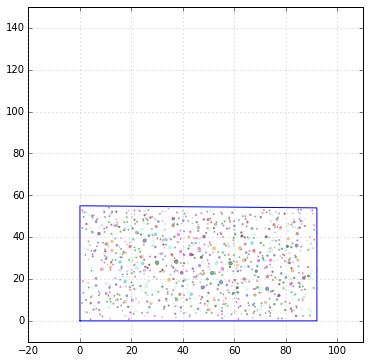

In [107]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.set_ylim(-10,150)
ax.set_xlim(-20,110)
ax.plot( *chacra2.exterior.xy )
points = ax.scatter(list(pob.individuos.x), 
           list(pob.individuos.y), 
           color=list(pob.individuos.color), 
           s=list(pob.individuos['Diametro.dosel']), 
           alpha=0.5)
ax.grid(color='gray', alpha=0.9)

In [103]:
from mpld3 import plugins
# Gráfico interactivo
#tooltip = plugins.PointLabelTooltip(points, pob.individuos.nombres)
#mpld3.plugins.connect(fig, tooltip)
mpld3.display(fig)


In [ ]:
import mplleaflet
mplleaflet.show()